In [7]:
## Initialization

%matplotlib inline
import matplotlib
# matplotlib.use('AGG')
import LFPy
import numpy as np
import os
import sys
import nest

from plotting_convention import *

import matplotlib.pyplot as plt
from os.path import join
from glob import glob

hbp_cells = '.'

sys.path.append(hbp_cells)
from hbp_cells import return_cell

l5_models = glob(join(".", 'L5_TTPC2*'))
cell_folder = l5_models[0]
cell_name = cell_folder.split('/')[-1]
print cell_folder


./L5_TTPC2_cADpyr232_1


In [47]:
def soma_response(stim_amp, source_pos=[-70, 0, 0]):
    dt = 2**-4
    T = 100
    start_T = -200

    sigma = 0.3

    amp = stim_amp
    stim_start_time = 20

    n_tsteps = int(T / dt + 1)
    t = np.arange(n_tsteps) * dt

    sources_x = np.array([source_pos[0]])
    sources_y = np.array([source_pos[1]])
    sources_z = np.array([source_pos[2]])

    def ext_field(x, y, z):
	ef = 0
	for s_idx in range(len(sources_x)):
	    ef += 1 / (4 * np.pi * sigma * np.sqrt((sources_x[s_idx] - x) ** 2 +
						   (sources_y[s_idx] - y) ** 2 +
						   (sources_z[s_idx] - z) ** 2))
	return ef

    cell = return_cell(cell_folder, cell_name, T, dt, start_T)

    pulse = np.zeros(n_tsteps)
    start_time_idx = np.argmin(np.abs(t - stim_start_time))
    pulse[start_time_idx:] = amp

    v_cell_ext = np.zeros((cell.totnsegs, n_tsteps))
    v_cell_ext[:, :] = ext_field(cell.xmid, cell.ymid, cell.zmid).reshape(cell.totnsegs, 1) * pulse.reshape(1, n_tsteps)

    cell.insert_v_ext(v_cell_ext, t)
    print("running simulation...")
    cell.simulate(rec_imem=False, rec_isyn=True, rec_vmem=True)
    np.save('vmem_cell.npy', cell.vmem)
    vmem = cell.vmem
    # print '[', amp, ',', np.max(cell.somav) - cell.somav[start_time_idx - 1], '],'
    return cell.somav[:]
    

In [3]:
def point_neuron(Ie):
    nest.ResetKernel()
    
    n = nest.Create('iaf_psc_delta', params={'I_e': Ie})
    vm = nest.Create('voltmeter', params={'interval': 0.1})
    sd = nest.Create('spike_detector')
    
    nest.Connect(vm, n)
    nest.Connect(n, sd)

    nest.Simulate(50)
    vme = nest.GetStatus(vm, 'events')[0]
    return vme['V_m'], vme['times']


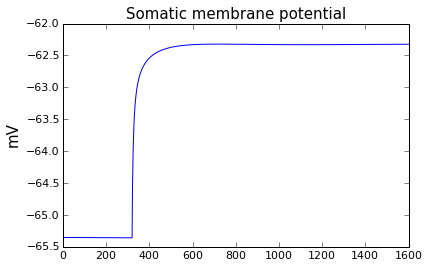


rec_imem = False, membrane currents will not be recorded!


Simulating  L5_TTPC2_cADpyr232_1
template cADpyr232_L5_TTPC2_8052133265 found!
template cADpyr232_L5_TTPC2_8052133265 found!
template cADpyr232_L5_TTPC2_8052133265 found!
Loading constants
template cADpyr232_L5_TTPC2_8052133265 exist already
running simulation...

In [48]:
somav = soma_response(-2000)

plt.title('Somatic membrane potential')
plt.ylabel('mV')
plt.plot(somav);




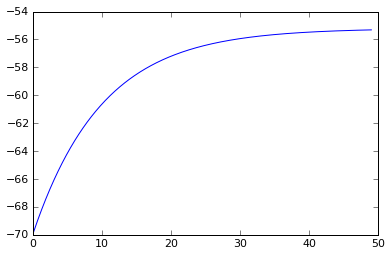

In [49]:
V, t = point_neuron(370.)
plt.plot(t, V);

In [6]:
xmax = np.max([np.max(cell.xend), np.max(sources_x)])
xmin = np.min([np.min(cell.xend), np.min(sources_x)])
ymax = np.max([np.max(cell.yend), np.max(sources_y)])
ymin = np.min([np.min(cell.yend), np.min(sources_y)])
zmax = np.max([np.max(cell.zend), np.max(sources_z)])
zmin = np.min([np.min(cell.zend), np.min(sources_z)])

v_field_ext_xz = np.zeros((100, 200))
xf = np.linspace(xmin, xmax, 100)
zf = np.linspace(zmin, zmax, 200)
for xidx, x in enumerate(xf):
    for zidx, z in enumerate(zf):
        v_field_ext_xz[xidx, zidx] = ext_field(x, 0, z) * amp

v_field_ext_xy = np.zeros((50, 50))
xf = np.linspace(xmin, xmax, 50)
yf = np.linspace(ymin, ymax, 50)
for xidx, x in enumerate(xf):
    for yidx, y in enumerate(yf):
        v_field_ext_xy[xidx, yidx] = ext_field(x, y, 0) * amp

vmax = np.max(np.abs(v_field_ext_xz)) / 10
vmin = -vmax

plt.close('all')
fig = plt.figure(figsize=[10, 5])
fig.subplots_adjust(wspace=0.7, hspace=0.8, top=0.9, bottom=0.12, right=0.94)

ax2 = plt.subplot(131, aspect=1, frameon=False, xticks=[], title='top view', xlabel='x ($\mu$m)', ylabel='y ($\mu$m)')
ax1 = plt.subplot(132, aspect=1, frameon=False, xticks=[], title='side view', xlabel='x ($\mu$m)', ylabel='z ($\mu$m)')
ax3 = plt.subplot(233, title='Somatic membrane\npotential', ylabel='mV')
ax6 = plt.subplot(236, ylim=[-5 - np.abs(amp)/1000., np.abs(amp)/1000. + 5],
                  ylabel='$\mu$A', title='Injected current')

ax3.plot(t, vmem[0, :], c='k', lw=2)
ax6.plot(t, pulse / 1000, lw=2, c='r')
ax1.plot(sources_x, sources_z, '*', c='y', ms=10,  lw=1)

img1 = ax1.imshow(v_field_ext_xz.T, extent=[xmin, xmax, zmin, zmax], origin='lower', interpolation='nearest', cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
cb = plt.colorbar(img1, ax=ax1, shrink=0.4)
cb.set_label('mV', labelpad=-2)

[ax1.plot([cell.xstart[idx], cell.xend[idx]], [cell.zstart[idx], cell.zend[idx]], c='k')
 for idx in range(cell.totnsegs)]
ax1.plot(cell.xmid[0], cell.zmid[0], 'o', ms=8, c='k', mec='none')

stim, = ax2.plot(sources_x, sources_y, '*', c='y', ms=10,  lw=1)
img2 = ax2.imshow(v_field_ext_xy.T, extent=[xmin, xmax, ymin, ymax], origin='lower', interpolation='nearest', cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
cb = plt.colorbar(img2, ax=ax2, shrink=0.4)#, ticks=tick_locations)
cb.set_label('mV', labelpad=-2)

[ax2.plot([cell.xstart[idx], cell.xend[idx]], [cell.ystart[idx], cell.yend[idx]], c='k')
 for idx in range(cell.totnsegs)]
ax2.plot(cell.xmid[0], cell.ymid[0], 'o', ms=8, c='k', mec='none')
fig.legend([stim], ['Injection point'], loc='lower center', frameon=False, numpoints=1)

for ax in fig.axes:
    ax.set_yticks(ax.get_yticks()[::2])
simplify_axes([ax3, ax6])

mark_subplots(ax1, 'B', xpos=-0.1, ypos=1.05)
mark_subplots(ax2, 'A', xpos=-0.1, ypos=1.1)
mark_subplots(ax3, 'C', xpos=-0.2, ypos=1.0)
mark_subplots(ax6, 'D', xpos=-0.2, ypos=1.0)

plt.show()

NameError: name 'cell' is not defined